In [1]:
import csv
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import sklearn
import time

In [2]:
import warnings
warnings.filterwarnings("ignore")

# create binary datasets

In [3]:
# 创建一个指定名称的文件夹。如果文件夹已经存在，它不会重复创建；如果创建过程中出现错误，它会捕获异常并打印错误信息
def folder(f_name): #this function creates a folder.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [4]:
# 从指定的 CSV 文件中读取数据，并提取其中某一列（Label 列）的唯一值，然后将这些唯一值排序并返回。
# 最后，代码调用了这个函数，并将返回的结果存储在变量 device_names 中。
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    target_names = list(map(str, target_names))
    #print(target_names)
    return target_names
train="./Aalto_BIG_train_IoTDevID.csv"
device_names=target_name(train)

In [5]:
# 创建了三个文件夹
folder("devicebasedcsvs")
folder("tree")
folder("results")

In [6]:
# 为每个设备创建一个数据集，其中包含：
# 当前设备的样本（最多 1000 个）。
# 非当前设备的样本（数量是设备样本的 5 倍）。
# 这些数据集被保存到 "./devicebasedcsvs/" 文件夹中，文件名以设备名称命名
for device in device_names:
    print(device)
    df=pd.read_csv(train)
    #print(df.groupby("Label").size())
    k= df['Label'].values==device
    del df["MAC"]
    k=list(k*1)
    size=k.count(1)
    df['Label']=k
    if size>1000:
        size=1000
    dev=df[df["Label"]==1]
    notdev=df[df["Label"]==0]
    dev=dev.sample(n=size, random_state=1)
    notdev=notdev.sample(n=size*5, random_state=1)
    df = pd.concat([dev, notdev])
    #df=df.groupby('Label').apply(lambda x: x.sample(n=size)).reset_index(drop = True)
    df.to_csv("./devicebasedcsvs/"+device+".csv",  index=False)


Aria
D-LinkCam
D-LinkDayCam
D-LinkDoorSensor
D-LinkHomeHub
D-LinkSensor
D-LinkSiren
D-LinkSwitch
D-LinkWaterSensor
EdimaxCam
EdimaxPlug1101W
EdimaxPlug2101W
EdnetCam
EdnetGateway
HomeMaticPlug
HueBridge
HueSwitch
Lightify
MAXGateway
SmarterCoffee
TP-LinkPlugHS100
TP-LinkPlugHS110
WeMoInsightSwitch
WeMoLink
WeMoSwitch
Withings
iKettle2


# create decision tree diagrams

In [7]:
# 用于将训练好的决策树模型可视化，并将其保存为 PDF 文件
from sklearn import tree
import graphviz
from graphviz import render

def ciz(name,model,feature_names,target_names):

    dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names=feature_names,  
                                class_names=target_names,
                                filled=True)

    # Draw graph
    #graph = graphviz.Source(dot_data) 
    graph = graphviz.Source(dot_data,format='pdf')    
    name="./tree/"+name[18:-4]
    graph.render(name, view=True)  

# ML Application

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from random import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

In [9]:
# 递归地搜索指定路径下所有符合特定格式的文件，并返回这些文件的完整路径列表。然后，代码调用了这个函数，
# 搜索 "./devicebasedcsvs" 文件夹下所有扩展名为 .csv 的文件，并将结果存储在变量 name_list 中
def find_the_way(path,file_format):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                files_add.append(os.path.join(r, file))  
    return files_add
name_list=find_the_way('./devicebasedcsvs','.csv')
name_list

['./devicebasedcsvs\\Aria.csv',
 './devicebasedcsvs\\D-LinkCam.csv',
 './devicebasedcsvs\\D-LinkDayCam.csv',
 './devicebasedcsvs\\D-LinkDoorSensor.csv',
 './devicebasedcsvs\\D-LinkHomeHub.csv',
 './devicebasedcsvs\\D-LinkSensor.csv',
 './devicebasedcsvs\\D-LinkSiren.csv',
 './devicebasedcsvs\\D-LinkSwitch.csv',
 './devicebasedcsvs\\D-LinkWaterSensor.csv',
 './devicebasedcsvs\\EdimaxCam.csv',
 './devicebasedcsvs\\EdimaxPlug1101W.csv',
 './devicebasedcsvs\\EdimaxPlug2101W.csv',
 './devicebasedcsvs\\EdnetCam.csv',
 './devicebasedcsvs\\EdnetGateway.csv',
 './devicebasedcsvs\\HomeMaticPlug.csv',
 './devicebasedcsvs\\HueBridge.csv',
 './devicebasedcsvs\\HueSwitch.csv',
 './devicebasedcsvs\\iKettle2.csv',
 './devicebasedcsvs\\Lightify.csv',
 './devicebasedcsvs\\MAXGateway.csv',
 './devicebasedcsvs\\SmarterCoffee.csv',
 './devicebasedcsvs\\TP-LinkPlugHS100.csv',
 './devicebasedcsvs\\TP-LinkPlugHS110.csv',
 './devicebasedcsvs\\WeMoInsightSwitch.csv',
 './devicebasedcsvs\\WeMoLink.csv',
 './devi

In [10]:
# 将一个决策树分类器实例存储在一个字典中，方便后续通过键名访问和使用该模型
ml_list={"DT":DecisionTreeClassifier()}

In [11]:
# 计算模型的性能指标（准确率、平衡准确率、精确率、召回率、F1 分数、Kappa 值）。
# 按类别汇总性能指标。
# 打印格式化的结果。
# 返回格式化的结果字符串和按类别汇总的性能指标。 
def score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii):
    precision=[]
    recall=[]
    f1=[]
    accuracy=[]
    total_time=[]
    kappa=[]
    accuracy_b=[]
    
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")        
    report = classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    precision.append(float(pr))
    recall.append(float(rc))
    f1.append(float(f_1))
    accuracy_b.append(balanced_accuracy_score( y_test,predict))
    accuracy.append(accuracy_score(y_test, predict))
    #clf.score(X_test, y_test))
    #print(balanced_accuracy_score( y_test,predict))
    #t_time.append(float((time.time()-second)) )
    kappa.append(round(float(sklearn.metrics.cohen_kappa_score(y_test, predict, 
    labels=None, weights=None, sample_weight=None)),15))
    print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-5s %-5s %-8s %-8s%-8s%-8s' % (dname,i,cv,ii[0:6],str(round(np.mean(accuracy),2)),str(round(np.mean(accuracy_b),2)),
        str(round(np.mean(precision),2)), str(round(np.mean(recall),2)),str(round(np.mean(f1),2)), 
        str(round(np.mean(kappa),2)),str(round(np.mean(train_time),2)),str(round(np.mean(test_time),2)),str(round(np.mean(test_time)+np.mean(train_time),2)),str(round(np.mean(altime),2))))
    lines=(str(dname)+","+str(i)+","+str(cv)+","+str(ii)+","+str(round(np.mean(accuracy),15))+","+str(round(np.mean(accuracy_b),15))+","+str(round(np.mean(precision),15))+","+ str(round(np.mean(recall),15))+","+str(round(np.mean(f1),15))+","+str(round(np.mean(kappa),15))+","+str(round(np.mean(train_time),15))+","+str(round(np.mean(test_time),15))+","+str(round(np.mean(test_time)+np.mean(train_time),15))+","+str(altime)+"\n")
    return lines,class_based_results

In [12]:
# 用于执行机器学习实验，包括数据预处理、模型训练、性能评估和结果可视化。
# 它支持多种机器学习算法，并将实验结果保存到 CSV 文件中。
# loop1：训练数据集的路径。
# loop2：未使用（可能是预留参数）。
# output_csv：保存实验结果的 CSV 文件路径。
# cols：指定数据集中需要使用的列名或索引。
# step：未使用（可能是预留参数）。
# Tree：布尔值，用于控制是否生成决策树的可视化文件。
def ML(loop1,loop2,output_csv,cols,step,Tree):
    fold=10  # 交叉验证的折数
    ths = open(output_csv, "w")
    ths.write("Dataset,T,CV,ML_algorithm,Acc,b_Acc,Precision, Recall , F1-score, kappa ,tra-Time,test-Time,total-Time,Al-Time\n")
    repetition=1  # 实验重复次数


    from sklearn.metrics import balanced_accuracy_score
    from sklearn.preprocessing import Normalizer
    # 打印实验结果的表头，用于控制台输出
    print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-5s %-5s %-8s %-8s%-8s%-8s'%
               ("Dataset","T","CV","ML_alg","Acc","b_Acc","Prec", "Rec" , "F1", "kap" ,"tra-T","test-T","total","al-time"))
    # 遍历 ml_list 中的每个模型，对每个模型执行指定次数的重复实验，使用 KFold 进行交叉验证，随机打乱数据
    for ii in ml_list:
        # 初始化按类别汇总的结果
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        # 初始化混淆矩阵
        cm=pd.DataFrame()
        cv=0
        for i in range(repetition):
            rnd = random()  # 生成随机数
            kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))
            # 1 数据加载和预处理
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )  # 加载数据集
            # 如果数据集包含 MAC 列，请取消注释
            #del df["MAC"] # if dataset has MAC colomn please uncomment this line
            feature_names=df.columns
            feature_names=feature_names[0:-1]  # 特征列名
            X =df[df.columns[0:-1]]  # 特征数据
            X=np.array(X)  # 转换为 NumPy 数组
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')  # 将目标列转换为分类编码
            y=df[df.columns[-1]].cat.codes  
            #scaler = Normalizer().fit(X)
            #X = scaler.transform(X)
            # summarize transformed data
            dname=loop1[18:-4]
            X.shape
            # 2 交叉验证，使用 KFold 分割数据集为训练集和测试集
            for train_index, test_index in kfold.split(X):

                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]  

      


                #dname=loop1  [6:-13]  
                results_y=[]
                
                results_y.append(y_test)


                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]
                
                # 3 模型训练和预测
                #machine learning algorithm is applied in this section
                clf = ml_list[ii]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)  # 训练模型
                train_time.append(float((time.time()-second)) )  # 记录训练时间
                second=time.time()
                predict =clf.predict(X_test)  # 预测测试集
                test_time.append(float((time.time()-second)) )  # 记录测试时间
                
                # 4 决策树可视化
                if Tree:
                    if cv==1:# creates a decision tree for the first step of cross-validation.
                        ciz(loop1,clf,feature_names,target_names)
                cv+=1
                
                # 5 性能评估
                altime=0
                lines,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)

                ths.write (lines)





                # 6 计算混淆矩阵，并将其累加到总混淆矩阵中
                df_cm = pd.DataFrame(confusion_matrix(y_test, predict))
                results_y.append(predict)
                if cm.empty:
                    cm =df_cm
                else:
                    cm = cm.add(df_cm, fill_value=0)

        # 7 实验结果汇总，打印按类别汇总的性能指标。使用 seaborn 绘制混淆矩阵的热力图，并显示结果
        print(class_based_results/(repetition*fold)) 
        graph_name=output_csv[:-4]+".pdf"     
        plt.figure(figsize = (5,3.5))
        sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names,fmt='', annot=True)
        #plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
        plt.show()
        #print(cm)
        print("\n\n\n") 
    ths.close()  

In [13]:
features=['pck_size', 'Ether_type', 'LLC_dsap', 'LLC_ssap', 'LLC_ctrl',
       'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_version', 'IP_ihl',
       'IP_tos', 'IP_len', 'IP_flags', 'IP_Z', 'IP_MF', 'IP_DF', 'IP_frag',
       'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type',
       'ICMP_code', 'ICMP_chksum', 'ICMP_id', 'ICMP_seq', 'ICMP_ts_ori',
       'ICMP_ts_rx', 'ICMP_ts_tx', 'ICMP_ptr', 'ICMP_reserved', 'ICMP_length',
        'ICMP_nexthopmtu', #'ICMP_unused',
          'TCP_seq',"IP_id",
       'TCP_ack', 'TCP_dataofs', 'TCP_reserved', 'TCP_flags', 'TCP_FIN',
       'TCP_SYN', 'TCP_RST', 'TCP_PSH', 'TCP_ACK', 'TCP_URG', 'TCP_ECE',
       'TCP_CWR', 'TCP_window', 'TCP_chksum', 'TCP_urgptr', 'TCP_options',
       'UDP_len', 'UDP_chksum', 'DHCP_options', 'BOOTP_op', 'BOOTP_htype',
       'BOOTP_hlen', 'BOOTP_hops', 'BOOTP_xid', 'BOOTP_secs', 'BOOTP_flags',
       'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_length', 'DNS_id',
       'DNS_qr', 'DNS_opcode', 'DNS_aa', 'DNS_tc', 'DNS_rd', 'DNS_ra', 'DNS_z',
       'DNS_ad', 'DNS_cd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount',
       'DNS_nscount', 'DNS_arcount', 'sport_class', 'dport_class',
       'sport_bare', 'dport_bare', 'TCP_sport', 'TCP_dport', 'UDP_sport',
       'UDP_dport', 'payload_bytes', 'entropy', 'Protocol', 'Label']

In [14]:
len(features)

91

Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
Aria            0   1   DT      0.99  0.99  0.97  0.99  0.98  0.97  0.0      0.0     0.0     0.0     
Aria            0   2   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.0      0.0     0.0     0.0     
Aria            0   3   DT      0.98  0.99  0.95  0.99  0.97  0.93  0.0      0.0     0.0     0.0     
Aria            0   4   DT      0.99  0.98  0.96  0.98  0.97  0.94  0.0      0.0     0.0     0.0     
Aria            0   5   DT      1.0   1.0   0.99  1.0   0.99  0.98  0.0      0.0     0.0     0.0     
Aria            0   6   DT      1.0   1.0   0.98  1.0   0.99  0.98  0.0      0.0     0.0     0.0     
Aria            0   7   DT      0.99  0.96  0.99  0.96  0.97  0.95  0.0      0.0     0.0     0.0     
Aria            0   8   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.0      0.0     0.0     0.0     
Aria            0   9   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.0      0.0  

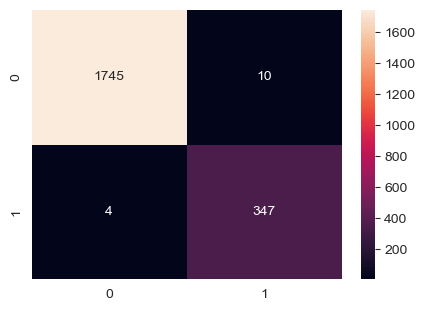




Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
D-LinkCam       0   1   DT      0.96  0.93  0.93  0.93  0.93  0.86  0.05     0.0     0.05    0.0     
D-LinkCam       0   2   DT      0.97  0.95  0.93  0.95  0.94  0.88  0.05     0.0     0.05    0.0     
D-LinkCam       0   3   DT      0.97  0.94  0.94  0.94  0.94  0.88  0.06     0.0     0.06    0.0     
D-LinkCam       0   4   DT      0.96  0.92  0.9   0.92  0.91  0.82  0.05     0.0     0.05    0.0     
D-LinkCam       0   5   DT      0.96  0.93  0.93  0.93  0.93  0.86  0.05     0.0     0.05    0.0     
D-LinkCam       0   6   DT      0.96  0.95  0.91  0.95  0.93  0.85  0.06     0.0     0.06    0.0     
D-LinkCam       0   7   DT      0.96  0.95  0.92  0.95  0.93  0.87  0.05     0.0     0.05    0.0     
D-LinkCam       0   8   DT      0.97  0.95  0.95  0.95  0.95  0.89  0.05     0.0     0.05    0.0     
D-LinkCam       0   9   DT      0.96  0.93  0.94  0.93  0.93  0.87  0.05     0.

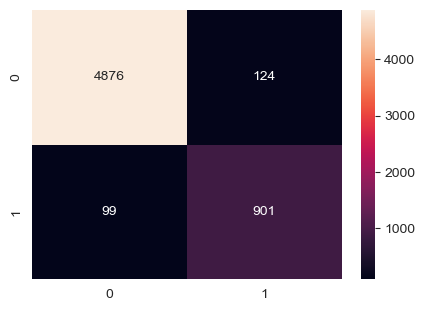





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
D-LinkDayCam    0   1   DT      0.98  0.96  0.98  0.96  0.97  0.94  0.02     0.0     0.02    0.0     
D-LinkDayCam    0   2   DT      0.99  0.96  0.99  0.96  0.97  0.95  0.01     0.0     0.01    0.0     
D-LinkDayCam    0   3   DT      0.98  0.97  0.96  0.97  0.97  0.93  0.01     0.0     0.01    0.0     
D-LinkDayCam    0   4   DT      0.98  0.97  0.97  0.97  0.97  0.94  0.01     0.0     0.01    0.0     
D-LinkDayCam    0   5   DT      0.98  0.98  0.96  0.98  0.97  0.94  0.01     0.0     0.01    0.0     
D-LinkDayCam    0   6   DT      0.99  0.98  0.99  0.98  0.98  0.96  0.01     0.0     0.01    0.0     
D-LinkDayCam    0   7   DT      0.99  0.98  0.99  0.98  0.98  0.97  0.01     0.0     0.01    0.0     
D-LinkDayCam    0   8   DT      0.99  1.0   0.98  1.0   0.99  0.98  0.01     0.0     0.01    0.0     
D-LinkDayCam    0   9   DT      0.98  0.97  0.95  0.97  0.96  0.92  0.01     0

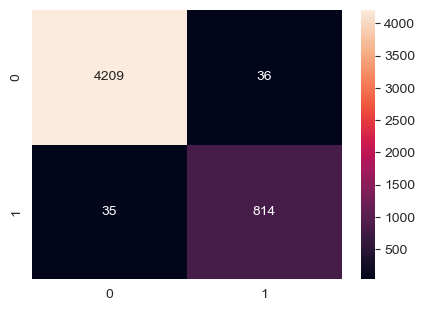





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
D-LinkDoorSensor 0   1   DT      0.97  0.95  0.95  0.95  0.95  0.9   0.03     0.0     0.03    0.0     
D-LinkDoorSensor 0   2   DT      0.99  0.98  0.98  0.98  0.98  0.95  0.03     0.0     0.03    0.0     
D-LinkDoorSensor 0   3   DT      0.98  0.96  0.95  0.96  0.96  0.91  0.03     0.0     0.03    0.0     
D-LinkDoorSensor 0   4   DT      0.98  0.97  0.96  0.97  0.96  0.93  0.03     0.0     0.03    0.0     
D-LinkDoorSensor 0   5   DT      0.97  0.97  0.94  0.97  0.95  0.91  0.03     0.0     0.03    0.0     
D-LinkDoorSensor 0   6   DT      0.98  0.97  0.94  0.97  0.96  0.91  0.03     0.0     0.03    0.0     
D-LinkDoorSensor 0   7   DT      0.96  0.93  0.94  0.93  0.94  0.87  0.03     0.0     0.03    0.0     
D-LinkDoorSensor 0   8   DT      0.95  0.91  0.91  0.91  0.91  0.82  0.03     0.0     0.04    0.0     
D-LinkDoorSensor 0   9   DT      0.97  0.95  0.94  0.95  0.94  0.89  0

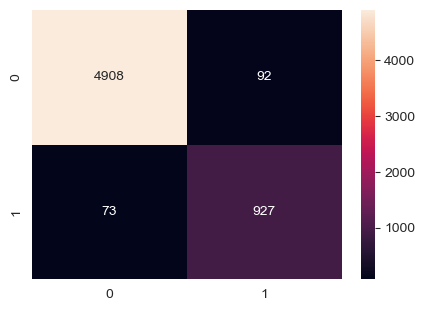





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
D-LinkHomeHub   0   1   DT      0.94  0.89  0.91  0.89  0.9   0.8   0.05     0.0     0.05    0.0     
D-LinkHomeHub   0   2   DT      0.94  0.88  0.89  0.88  0.88  0.76  0.05     0.0     0.05    0.0     
D-LinkHomeHub   0   3   DT      0.94  0.9   0.89  0.9   0.89  0.78  0.05     0.0     0.05    0.0     
D-LinkHomeHub   0   4   DT      0.93  0.86  0.87  0.86  0.86  0.72  0.04     0.0     0.05    0.0     
D-LinkHomeHub   0   5   DT      0.93  0.87  0.87  0.87  0.87  0.74  0.04     0.0     0.04    0.0     
D-LinkHomeHub   0   6   DT      0.94  0.87  0.89  0.87  0.88  0.75  0.05     0.0     0.05    0.0     
D-LinkHomeHub   0   7   DT      0.94  0.88  0.9   0.88  0.89  0.78  0.04     0.0     0.04    0.0     
D-LinkHomeHub   0   8   DT      0.93  0.86  0.88  0.86  0.87  0.73  0.04     0.0     0.04    0.0     
D-LinkHomeHub   0   9   DT      0.93  0.89  0.89  0.89  0.89  0.78  0.05     0

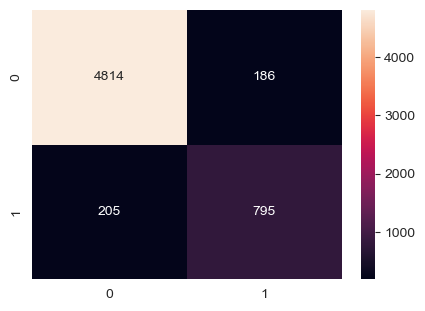





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
D-LinkSensor    0   1   DT      0.93  0.88  0.87  0.88  0.87  0.75  0.03     0.0     0.03    0.0     
D-LinkSensor    0   2   DT      0.94  0.88  0.89  0.88  0.88  0.77  0.03     0.0     0.03    0.0     
D-LinkSensor    0   3   DT      0.94  0.9   0.91  0.9   0.91  0.81  0.04     0.0     0.04    0.0     
D-LinkSensor    0   4   DT      0.93  0.89  0.88  0.89  0.88  0.77  0.04     0.0     0.04    0.0     
D-LinkSensor    0   5   DT      0.93  0.88  0.89  0.88  0.89  0.77  0.04     0.0     0.04    0.0     
D-LinkSensor    0   6   DT      0.92  0.86  0.88  0.86  0.87  0.74  0.03     0.0     0.03    0.0     
D-LinkSensor    0   7   DT      0.91  0.85  0.81  0.85  0.83  0.65  0.04     0.0     0.04    0.0     
D-LinkSensor    0   8   DT      0.91  0.85  0.84  0.85  0.84  0.69  0.05     0.0     0.05    0.0     
D-LinkSensor    0   9   DT      0.94  0.88  0.89  0.88  0.88  0.77  0.04     0

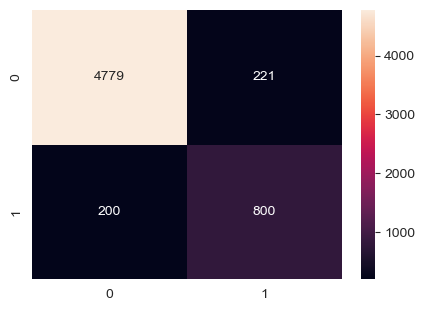





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
D-LinkSiren     0   1   DT      0.91  0.85  0.83  0.85  0.84  0.68  0.04     0.0     0.04    0.0     
D-LinkSiren     0   2   DT      0.91  0.84  0.83  0.84  0.84  0.67  0.04     0.0     0.04    0.0     
D-LinkSiren     0   3   DT      0.92  0.88  0.87  0.88  0.87  0.75  0.04     0.0     0.04    0.0     
D-LinkSiren     0   4   DT      0.92  0.86  0.85  0.86  0.85  0.71  0.04     0.0     0.04    0.0     
D-LinkSiren     0   5   DT      0.93  0.88  0.88  0.88  0.88  0.75  0.04     0.0     0.04    0.0     
D-LinkSiren     0   6   DT      0.92  0.87  0.87  0.87  0.87  0.73  0.04     0.0     0.04    0.0     
D-LinkSiren     0   7   DT      0.92  0.86  0.86  0.86  0.86  0.72  0.04     0.0     0.04    0.0     
D-LinkSiren     0   8   DT      0.93  0.87  0.88  0.87  0.88  0.75  0.03     0.0     0.03    0.0     
D-LinkSiren     0   9   DT      0.94  0.88  0.88  0.88  0.88  0.77  0.03     0

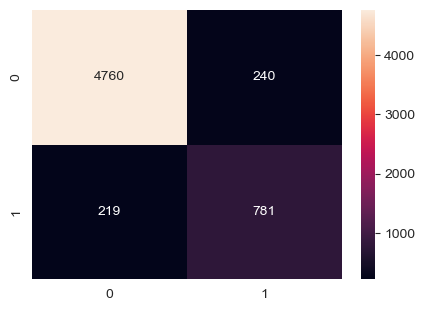





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
D-LinkSwitch    0   1   DT      0.94  0.91  0.9   0.91  0.9   0.8   0.04     0.0     0.05    0.0     
D-LinkSwitch    0   2   DT      0.95  0.93  0.9   0.93  0.91  0.83  0.04     0.0     0.04    0.0     
D-LinkSwitch    0   3   DT      0.95  0.92  0.92  0.92  0.92  0.83  0.04     0.0     0.04    0.0     
D-LinkSwitch    0   4   DT      0.96  0.93  0.91  0.93  0.92  0.84  0.05     0.0     0.05    0.0     
D-LinkSwitch    0   5   DT      0.94  0.91  0.89  0.91  0.9   0.8   0.04     0.0     0.04    0.0     
D-LinkSwitch    0   6   DT      0.94  0.9   0.9   0.9   0.9   0.8   0.04     0.0     0.04    0.0     
D-LinkSwitch    0   7   DT      0.95  0.91  0.91  0.91  0.91  0.82  0.05     0.0     0.05    0.0     
D-LinkSwitch    0   8   DT      0.95  0.91  0.92  0.91  0.92  0.83  0.03     0.0     0.03    0.0     
D-LinkSwitch    0   9   DT      0.94  0.9   0.88  0.9   0.89  0.78  0.04     0

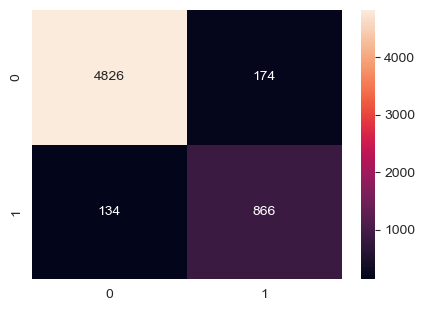





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
D-LinkWaterSensor 0   1   DT      0.95  0.9   0.92  0.9   0.91  0.81  0.05     0.0     0.05    0.0     
D-LinkWaterSensor 0   2   DT      0.92  0.86  0.86  0.86  0.86  0.72  0.04     0.0     0.04    0.0     
D-LinkWaterSensor 0   3   DT      0.92  0.9   0.87  0.9   0.88  0.77  0.05     0.0     0.05    0.0     
D-LinkWaterSensor 0   4   DT      0.93  0.89  0.87  0.89  0.88  0.75  0.04     0.0     0.04    0.0     
D-LinkWaterSensor 0   5   DT      0.93  0.88  0.88  0.88  0.88  0.76  0.04     0.0     0.04    0.0     
D-LinkWaterSensor 0   6   DT      0.96  0.92  0.91  0.92  0.92  0.83  0.05     0.0     0.05    0.0     
D-LinkWaterSensor 0   7   DT      0.95  0.92  0.91  0.92  0.92  0.83  0.04     0.0     0.04    0.0     
D-LinkWaterSensor 0   8   DT      0.94  0.87  0.89  0.87  0.88  0.75  0.04     0.0     0.04    0.0     
D-LinkWaterSensor 0   9   DT      0.92  0.86  0.87  0.86  0.86

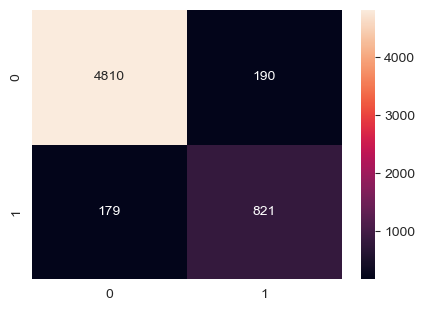





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
EdimaxCam       0   1   DT      0.97  0.98  0.92  0.98  0.94  0.88  0.01     0.0     0.01    0.0     
EdimaxCam       0   2   DT      0.98  0.98  0.96  0.98  0.97  0.94  0.01     0.0     0.01    0.0     
EdimaxCam       0   3   DT      0.98  0.98  0.96  0.98  0.97  0.95  0.01     0.0     0.01    0.0     
EdimaxCam       0   4   DT      0.98  0.98  0.97  0.98  0.97  0.94  0.01     0.0     0.01    0.0     
EdimaxCam       0   5   DT      0.97  0.95  0.95  0.95  0.95  0.9   0.01     0.0     0.01    0.0     
EdimaxCam       0   6   DT      0.98  0.98  0.95  0.98  0.97  0.93  0.01     0.0     0.01    0.0     
EdimaxCam       0   7   DT      0.98  0.96  0.95  0.96  0.96  0.92  0.01     0.0     0.01    0.0     
EdimaxCam       0   8   DT      0.99  0.99  0.98  0.99  0.98  0.96  0.01     0.0     0.01    0.0     
EdimaxCam       0   9   DT      0.97  0.95  0.93  0.95  0.94  0.87  0.01     0

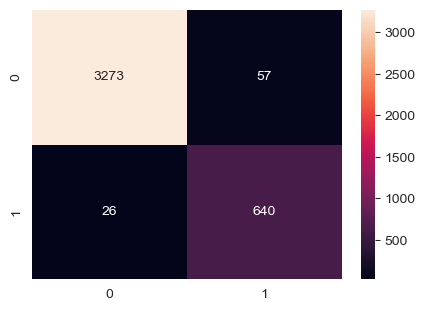





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
EdimaxPlug1101W 0   1   DT      0.97  0.95  0.95  0.95  0.95  0.9   0.03     0.0     0.03    0.0     
EdimaxPlug1101W 0   2   DT      0.98  0.96  0.98  0.96  0.97  0.94  0.03     0.0     0.03    0.0     
EdimaxPlug1101W 0   3   DT      0.98  0.97  0.96  0.97  0.97  0.93  0.03     0.0     0.03    0.0     
EdimaxPlug1101W 0   4   DT      0.99  0.99  0.96  0.99  0.97  0.95  0.03     0.0     0.03    0.0     
EdimaxPlug1101W 0   5   DT      0.98  0.97  0.95  0.97  0.96  0.92  0.03     0.0     0.03    0.0     
EdimaxPlug1101W 0   6   DT      0.98  0.98  0.94  0.98  0.96  0.92  0.03     0.0     0.03    0.0     
EdimaxPlug1101W 0   7   DT      0.98  0.97  0.96  0.97  0.97  0.93  0.03     0.0     0.03    0.0     
EdimaxPlug1101W 0   8   DT      0.98  0.97  0.97  0.97  0.97  0.94  0.03     0.0     0.03    0.0     
EdimaxPlug1101W 0   9   DT      0.97  0.97  0.94  0.97  0.95  0.9   0.03     0

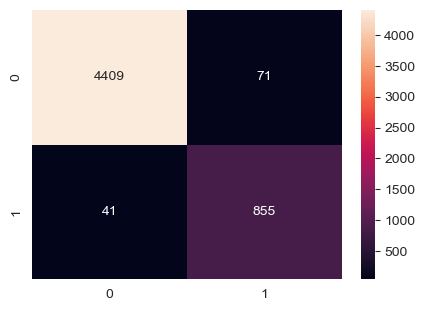





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
EdimaxPlug2101W 0   1   DT      0.98  0.96  0.96  0.96  0.96  0.92  0.02     0.0     0.02    0.0     
EdimaxPlug2101W 0   2   DT      0.98  0.98  0.96  0.98  0.97  0.94  0.02     0.0     0.02    0.0     
EdimaxPlug2101W 0   3   DT      0.98  0.96  0.95  0.96  0.96  0.91  0.02     0.0     0.02    0.0     
EdimaxPlug2101W 0   4   DT      0.97  0.96  0.93  0.96  0.94  0.89  0.02     0.0     0.02    0.0     
EdimaxPlug2101W 0   5   DT      0.99  0.99  0.96  0.99  0.97  0.95  0.02     0.0     0.02    0.0     
EdimaxPlug2101W 0   6   DT      0.98  0.95  0.97  0.95  0.96  0.92  0.02     0.0     0.02    0.0     
EdimaxPlug2101W 0   7   DT      0.97  0.95  0.96  0.95  0.95  0.91  0.02     0.0     0.02    0.0     
EdimaxPlug2101W 0   8   DT      0.99  0.97  0.98  0.97  0.98  0.95  0.02     0.0     0.02    0.0     
EdimaxPlug2101W 0   9   DT      0.98  0.97  0.96  0.97  0.97  0.93  0.02     0

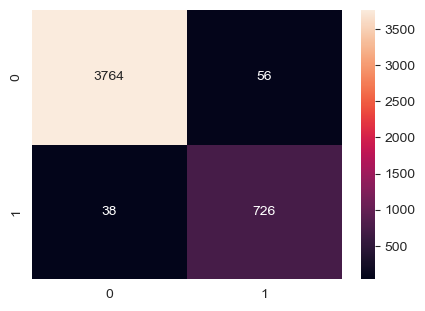





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
EdnetCam        0   1   DT      0.96  0.95  0.9   0.95  0.92  0.85  0.01     0.0     0.01    0.0     
EdnetCam        0   2   DT      0.97  0.94  0.94  0.94  0.94  0.89  0.0      0.0     0.0     0.0     
EdnetCam        0   3   DT      0.98  0.97  0.96  0.97  0.97  0.93  0.0      0.0     0.01    0.0     
EdnetCam        0   4   DT      0.98  0.97  0.98  0.97  0.98  0.96  0.0      0.0     0.0     0.0     
EdnetCam        0   5   DT      0.98  0.96  0.97  0.96  0.97  0.93  0.0      0.0     0.0     0.0     
EdnetCam        0   6   DT      0.99  0.99  0.97  0.99  0.98  0.96  0.01     0.0     0.01    0.0     
EdnetCam        0   7   DT      0.97  0.96  0.94  0.96  0.95  0.9   0.0      0.0     0.0     0.0     
EdnetCam        0   8   DT      0.98  0.97  0.98  0.97  0.97  0.95  0.0      0.0     0.01    0.0     
EdnetCam        0   9   DT      0.99  1.0   0.99  1.0   0.99  0.98  0.0      0

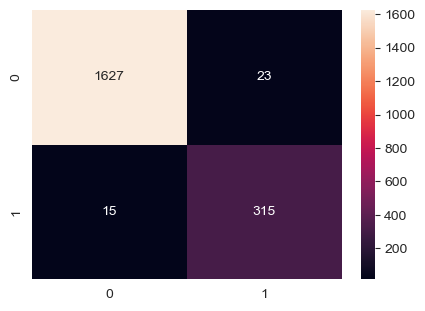





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
EdnetGateway    0   1   DT      0.99  0.98  0.98  0.98  0.98  0.96  0.01     0.0     0.01    0.0     
EdnetGateway    0   2   DT      0.98  0.98  0.97  0.98  0.97  0.94  0.01     0.0     0.01    0.0     
EdnetGateway    0   3   DT      0.99  0.98  0.98  0.98  0.98  0.95  0.01     0.0     0.01    0.0     
EdnetGateway    0   4   DT      0.99  0.99  0.99  0.99  0.99  0.98  0.01     0.0     0.01    0.0     
EdnetGateway    0   5   DT      0.98  0.98  0.96  0.98  0.97  0.94  0.01     0.0     0.01    0.0     
EdnetGateway    0   6   DT      0.99  1.0   0.98  1.0   0.99  0.98  0.01     0.0     0.01    0.0     
EdnetGateway    0   7   DT      0.98  0.97  0.97  0.97  0.97  0.93  0.01     0.0     0.01    0.0     
EdnetGateway    0   8   DT      0.98  0.96  0.97  0.96  0.97  0.93  0.01     0.0     0.01    0.0     
EdnetGateway    0   9   DT      0.98  0.98  0.96  0.98  0.97  0.94  0.01     0

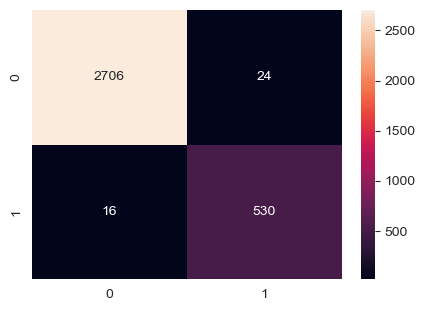





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
HomeMaticPlug   0   1   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0.0     0.01    0.0     
HomeMaticPlug   0   2   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0.0     0.01    0.0     
HomeMaticPlug   0   3   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0.0     0.01    0.0     
HomeMaticPlug   0   4   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.0      0.0     0.01    0.0     
HomeMaticPlug   0   5   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.0      0.0     0.01    0.0     
HomeMaticPlug   0   6   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0.0     0.01    0.0     
HomeMaticPlug   0   7   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0.0     0.01    0.0     
HomeMaticPlug   0   8   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0.0     0.01    0.0     
HomeMaticPlug   0   9   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0

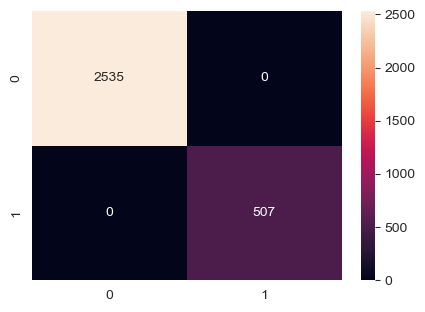





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
HueBridge       0   1   DT      0.94  0.88  0.89  0.88  0.89  0.77  0.05     0.0     0.05    0.0     
HueBridge       0   2   DT      0.92  0.86  0.85  0.86  0.86  0.72  0.05     0.0     0.05    0.0     
HueBridge       0   3   DT      0.94  0.87  0.9   0.87  0.89  0.78  0.05     0.0     0.05    0.0     
HueBridge       0   4   DT      0.93  0.87  0.89  0.87  0.88  0.76  0.05     0.0     0.05    0.0     
HueBridge       0   5   DT      0.94  0.89  0.88  0.89  0.89  0.77  0.05     0.0     0.05    0.0     
HueBridge       0   6   DT      0.92  0.85  0.86  0.85  0.86  0.71  0.04     0.0     0.05    0.0     
HueBridge       0   7   DT      0.94  0.87  0.9   0.87  0.88  0.77  0.05     0.0     0.05    0.0     
HueBridge       0   8   DT      0.92  0.85  0.86  0.85  0.86  0.71  0.05     0.0     0.05    0.0     
HueBridge       0   9   DT      0.92  0.89  0.84  0.89  0.86  0.73  0.05     0

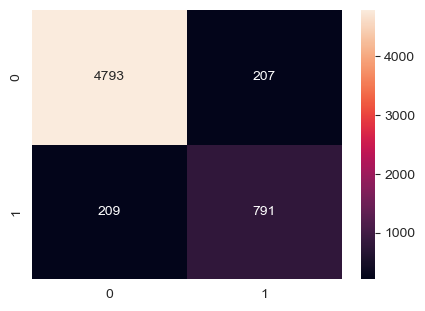





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
HueSwitch       0   1   DT      0.94  0.89  0.92  0.89  0.9   0.81  0.04     0.0     0.04    0.0     
HueSwitch       0   2   DT      0.95  0.92  0.89  0.92  0.9   0.81  0.04     0.0     0.04    0.0     
HueSwitch       0   3   DT      0.92  0.85  0.88  0.85  0.86  0.73  0.03     0.0     0.03    0.0     
HueSwitch       0   4   DT      0.94  0.88  0.89  0.88  0.88  0.77  0.04     0.0     0.04    0.0     
HueSwitch       0   5   DT      0.94  0.92  0.9   0.92  0.91  0.82  0.03     0.0     0.03    0.0     
HueSwitch       0   6   DT      0.94  0.86  0.89  0.86  0.87  0.74  0.04     0.0     0.04    0.0     
HueSwitch       0   7   DT      0.93  0.86  0.89  0.86  0.87  0.75  0.03     0.0     0.03    0.0     
HueSwitch       0   8   DT      0.94  0.88  0.88  0.88  0.88  0.76  0.04     0.0     0.04    0.0     
HueSwitch       0   9   DT      0.95  0.92  0.91  0.92  0.91  0.82  0.04     0

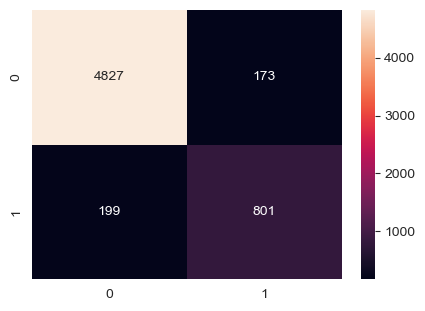





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
iKettle2        0   1   DT      0.97  0.98  0.95  0.98  0.96  0.93  0.0      0.0     0.0     0.0     
iKettle2        0   2   DT      0.97  0.95  0.95  0.95  0.95  0.9   0.0      0.0     0.0     0.0     
iKettle2        0   3   DT      0.97  0.95  0.95  0.95  0.95  0.89  0.0      0.0     0.0     0.0     
iKettle2        0   4   DT      0.99  0.96  0.99  0.96  0.98  0.95  0.0      0.0     0.0     0.0     
iKettle2        0   5   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.0      0.0     0.0     0.0     
iKettle2        0   6   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.0      0.0     0.0     0.0     
iKettle2        0   7   DT      0.97  0.93  0.93  0.93  0.93  0.86  0.0      0.0     0.0     0.0     
iKettle2        0   8   DT      0.97  0.95  0.95  0.95  0.95  0.89  0.0      0.0     0.0     0.0     
iKettle2        0   9   DT      0.97  0.98  0.91  0.98  0.94  0.88  0.0      0

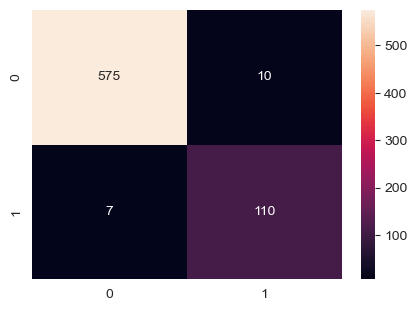





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
Lightify        0   1   DT      0.99  0.96  0.99  0.96  0.97  0.94  0.01     0.0     0.01    0.0     
Lightify        0   2   DT      1.0   0.99  0.99  0.99  0.99  0.98  0.01     0.0     0.01    0.0     
Lightify        0   3   DT      1.0   1.0   1.0   1.0   1.0   0.99  0.01     0.0     0.01    0.0     
Lightify        0   4   DT      1.0   0.99  0.99  0.99  0.99  0.98  0.01     0.0     0.01    0.0     
Lightify        0   5   DT      0.99  0.99  0.98  0.99  0.99  0.97  0.01     0.0     0.01    0.0     
Lightify        0   6   DT      0.99  0.98  0.99  0.98  0.99  0.97  0.01     0.0     0.01    0.0     
Lightify        0   7   DT      1.0   0.99  0.99  0.99  0.99  0.99  0.01     0.0     0.01    0.0     
Lightify        0   8   DT      1.0   0.99  0.99  0.99  0.99  0.98  0.01     0.0     0.01    0.0     
Lightify        0   9   DT      1.0   0.99  0.99  0.99  0.99  0.98  0.01     0

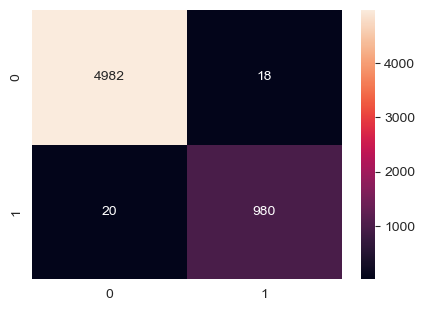





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
MAXGateway      0   1   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0.0     0.01    0.0     
MAXGateway      0   2   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0.0     0.01    0.0     
MAXGateway      0   3   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0.0     0.01    0.0     
MAXGateway      0   4   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0.0     0.01    0.0     
MAXGateway      0   5   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0.0     0.01    0.0     
MAXGateway      0   6   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0.0     0.01    0.0     
MAXGateway      0   7   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0.0     0.01    0.0     
MAXGateway      0   8   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0.0     0.01    0.0     
MAXGateway      0   9   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0

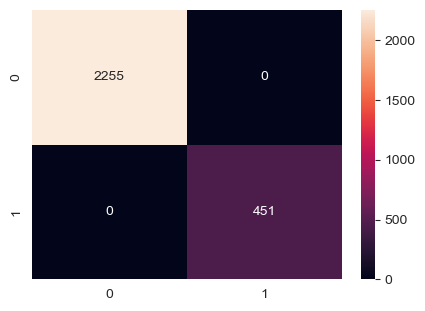





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
SmarterCoffee   0   1   DT      0.97  0.94  0.98  0.94  0.96  0.92  0.0      0.0     0.0     0.0     
SmarterCoffee   0   2   DT      0.99  0.99  0.95  0.99  0.97  0.94  0.0      0.0     0.0     0.0     
SmarterCoffee   0   3   DT      0.99  0.99  0.97  0.99  0.98  0.96  0.0      0.0     0.0     0.0     
SmarterCoffee   0   4   DT      0.97  0.98  0.93  0.98  0.95  0.91  0.0      0.0     0.0     0.0     
SmarterCoffee   0   5   DT      0.99  0.99  0.95  0.99  0.97  0.94  0.0      0.0     0.0     0.0     
SmarterCoffee   0   6   DT      0.99  0.94  0.99  0.94  0.97  0.93  0.0      0.0     0.0     0.0     
SmarterCoffee   0   7   DT      0.99  0.99  0.96  0.99  0.98  0.95  0.0      0.0     0.0     0.0     
SmarterCoffee   0   8   DT      0.97  0.9   0.98  0.9   0.94  0.87  0.0      0.0     0.0     0.0     
SmarterCoffee   0   9   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.0      0

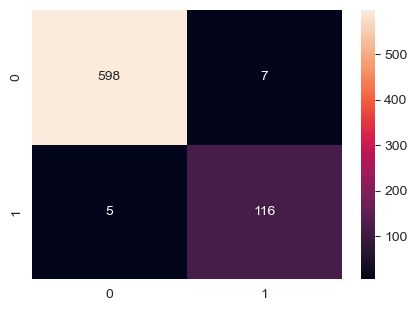





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
TP-LinkPlugHS100 0   1   DT      0.98  0.96  0.97  0.96  0.96  0.92  0.01     0.0     0.01    0.0     
TP-LinkPlugHS100 0   2   DT      0.99  0.98  0.97  0.98  0.98  0.95  0.01     0.0     0.01    0.0     
TP-LinkPlugHS100 0   3   DT      0.98  0.98  0.97  0.98  0.97  0.94  0.01     0.0     0.01    0.0     
TP-LinkPlugHS100 0   4   DT      0.98  0.99  0.95  0.99  0.97  0.94  0.01     0.0     0.01    0.0     
TP-LinkPlugHS100 0   5   DT      0.98  0.97  0.98  0.97  0.98  0.95  0.01     0.0     0.01    0.0     
TP-LinkPlugHS100 0   6   DT      0.99  0.98  0.97  0.98  0.98  0.96  0.01     0.0     0.01    0.0     
TP-LinkPlugHS100 0   7   DT      0.97  0.96  0.93  0.96  0.94  0.89  0.01     0.0     0.01    0.0     
TP-LinkPlugHS100 0   8   DT      0.98  0.96  0.95  0.96  0.95  0.9   0.01     0.0     0.01    0.0     
TP-LinkPlugHS100 0   9   DT      0.99  0.99  0.97  0.99  0.98  0.96  0

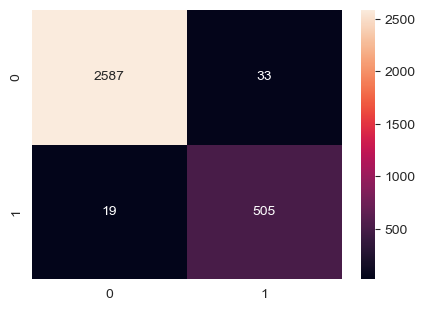





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
TP-LinkPlugHS110 0   1   DT      0.99  0.98  0.97  0.98  0.98  0.96  0.01     0.0     0.01    0.0     
TP-LinkPlugHS110 0   2   DT      0.98  0.98  0.97  0.98  0.97  0.94  0.01     0.0     0.01    0.0     
TP-LinkPlugHS110 0   3   DT      0.99  0.99  0.97  0.99  0.98  0.96  0.01     0.0     0.01    0.0     
TP-LinkPlugHS110 0   4   DT      0.98  0.96  0.96  0.96  0.96  0.91  0.01     0.0     0.01    0.0     
TP-LinkPlugHS110 0   5   DT      0.98  0.96  0.95  0.96  0.95  0.91  0.01     0.0     0.01    0.0     
TP-LinkPlugHS110 0   6   DT      0.98  0.98  0.94  0.98  0.96  0.92  0.01     0.0     0.01    0.0     
TP-LinkPlugHS110 0   7   DT      0.97  0.92  0.93  0.92  0.93  0.86  0.01     0.0     0.01    0.0     
TP-LinkPlugHS110 0   8   DT      0.97  0.96  0.95  0.96  0.95  0.9   0.01     0.0     0.01    0.0     
TP-LinkPlugHS110 0   9   DT      0.97  0.96  0.95  0.96  0.95  0.91  0

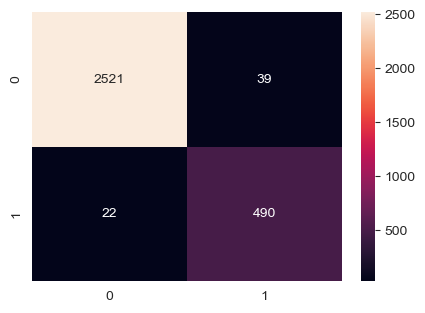





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
WeMoInsightSwitch 0   1   DT      0.97  0.94  0.95  0.94  0.95  0.89  0.03     0.0     0.03    0.0     
WeMoInsightSwitch 0   2   DT      0.97  0.95  0.96  0.95  0.95  0.91  0.03     0.0     0.03    0.0     
WeMoInsightSwitch 0   3   DT      0.97  0.94  0.94  0.94  0.94  0.88  0.03     0.0     0.03    0.0     
WeMoInsightSwitch 0   4   DT      0.95  0.91  0.93  0.91  0.92  0.83  0.03     0.0     0.03    0.0     
WeMoInsightSwitch 0   5   DT      0.98  0.94  0.97  0.94  0.95  0.9   0.03     0.0     0.03    0.0     
WeMoInsightSwitch 0   6   DT      0.95  0.9   0.91  0.9   0.91  0.82  0.02     0.0     0.02    0.0     
WeMoInsightSwitch 0   7   DT      0.95  0.91  0.9   0.91  0.9   0.81  0.03     0.0     0.03    0.0     
WeMoInsightSwitch 0   8   DT      0.97  0.97  0.94  0.97  0.96  0.91  0.03     0.0     0.03    0.0     
WeMoInsightSwitch 0   9   DT      0.98  0.95  0.95  0.95  0.95

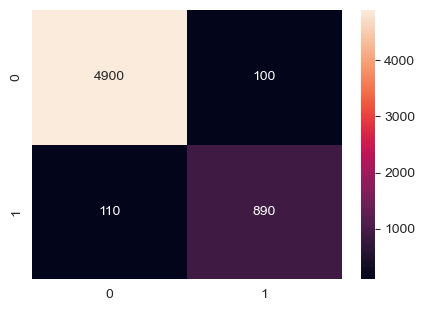




Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
WeMoLink        0   1   DT      0.98  0.96  0.97  0.96  0.96  0.93  0.04     0.0     0.04    0.0     
WeMoLink        0   2   DT      0.98  0.97  0.96  0.97  0.96  0.92  0.04     0.0     0.04    0.0     
WeMoLink        0   3   DT      0.98  0.96  0.95  0.96  0.95  0.91  0.04     0.0     0.04    0.0     
WeMoLink        0   4   DT      0.97  0.95  0.93  0.95  0.94  0.88  0.04     0.0     0.04    0.0     
WeMoLink        0   5   DT      0.95  0.91  0.94  0.91  0.92  0.85  0.04     0.0     0.04    0.0     
WeMoLink        0   6   DT      0.98  0.96  0.95  0.96  0.95  0.91  0.04     0.0     0.04    0.0     
WeMoLink        0   7   DT      0.98  0.98  0.97  0.98  0.97  0.95  0.04     0.0     0.04    0.0     
WeMoLink        0   8   DT      0.97  0.93  0.94  0.93  0.94  0.87  0.04     0.0     0.04    0.0     
WeMoLink        0   9   DT      0.96  0.93  0.94  0.93  0.94  0.87  0.04     0.

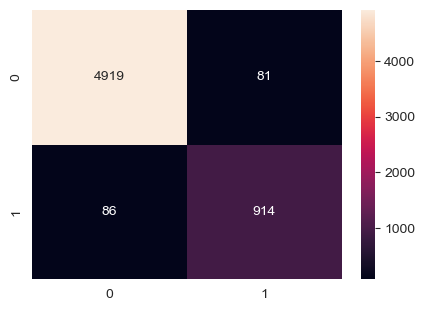





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
WeMoSwitch      0   1   DT      0.97  0.96  0.94  0.96  0.95  0.9   0.03     0.0     0.03    0.0     
WeMoSwitch      0   2   DT      0.96  0.95  0.93  0.95  0.94  0.87  0.03     0.0     0.03    0.0     
WeMoSwitch      0   3   DT      0.97  0.95  0.94  0.95  0.95  0.89  0.03     0.0     0.03    0.0     
WeMoSwitch      0   4   DT      0.97  0.95  0.94  0.95  0.94  0.89  0.03     0.0     0.04    0.0     
WeMoSwitch      0   5   DT      0.97  0.94  0.93  0.94  0.94  0.88  0.03     0.0     0.03    0.0     
WeMoSwitch      0   6   DT      0.97  0.96  0.94  0.96  0.95  0.89  0.03     0.0     0.03    0.0     
WeMoSwitch      0   7   DT      0.96  0.93  0.93  0.93  0.93  0.86  0.03     0.0     0.03    0.0     
WeMoSwitch      0   8   DT      0.96  0.95  0.92  0.95  0.93  0.87  0.03     0.0     0.03    0.0     
WeMoSwitch      0   9   DT      0.96  0.94  0.93  0.94  0.93  0.87  0.03     0

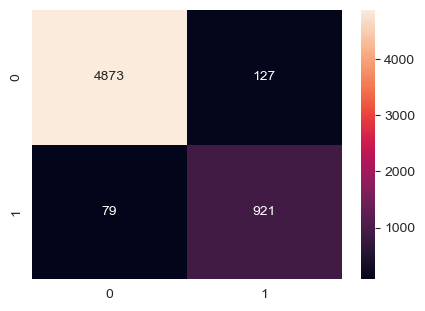





Dataset         T   CV  ML_alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
Withings        0   1   DT      0.99  0.99  0.99  0.99  0.99  0.98  0.01     0.0     0.01    0.0     
Withings        0   2   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0.0     0.01    0.0     
Withings        0   3   DT      1.0   1.0   0.99  1.0   0.99  0.99  0.01     0.0     0.01    0.0     
Withings        0   4   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0.0     0.01    0.0     
Withings        0   5   DT      1.0   1.0   0.99  1.0   0.99  0.99  0.01     0.0     0.01    0.0     
Withings        0   6   DT      1.0   0.99  1.0   0.99  0.99  0.99  0.01     0.0     0.01    0.0     
Withings        0   7   DT      0.99  0.97  0.99  0.97  0.98  0.96  0.01     0.0     0.01    0.0     
Withings        0   8   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0.0     0.01    0.0     
Withings        0   9   DT      1.0   1.0   1.0   1.0   1.0   1.0   0.01     0

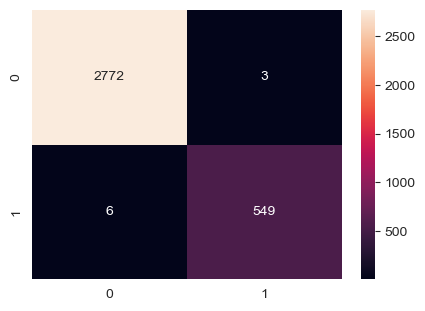

In [15]:
# 遍历 name_list 中的每个文件路径，针对每个文件执行机器学习实验，并将结果保存到指定的 CSV 文件中
for i in name_list:
    step=1
    Tree=False # It uses the graphviz library.
    output_csv="./results/"+i[18:-4]+"_"+str(step)+"_"+str(Tree)+".csv"
    target_names=target_name(i)
    ML(i,i,output_csv,features,step,Tree)   

#### voting process for device csv files
#### each voting action is saved in a separate csv file


# IMPORTANT !!!
# if you have any error about xverse please see: https://github.com/kahramankostas/IoTDevIDv2/issues/2

### and be sure about requirements.txt



In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2, RFE
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler

# 假设 name_list 是文件路径列表，features 是需要加载的列名列表
for file_path in name_list:
    # 读取数据集
    df = pd.read_csv(file_path, usecols=features)

    # 分离特征和目标变量
    X = df.iloc[:, :-1]  # 所有行，除最后一列外的所有列
    y = df.iloc[:, -1]   # 最后一列为目标变量

    # 使用随机森林计算特征重要性
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importances = pd.DataFrame({
        "Variable_Name": X.columns,
        "Random_Forest": rf.feature_importances_
    })

    # 使用卡方检验计算特征重要性
    chi2_scores, _ = chi2(X, y)
    feature_importances["Chi_Square"] = chi2_scores

    # 使用递归特征消除（RFE）
    rfe = RFE(estimator=rf, n_features_to_select=1)
    rfe.fit(X, y)
    feature_importances["Recursive_Feature_Elimination"] = rfe.ranking_

    # 使用 L1 正则化（Lasso）
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    lasso = Lasso(alpha=0.1)
    lasso.fit(X_scaled, y)
    feature_importances["L_One"] = np.abs(lasso.coef_)

    # 计算投票结果
    feature_importances["Votes"] = (
        (feature_importances["Random_Forest"] > feature_importances["Random_Forest"].mean()).astype(int) +
        (feature_importances["Chi_Square"] > feature_importances["Chi_Square"].mean()).astype(int) +
        (feature_importances["Recursive_Feature_Elimination"] == 1).astype(int) +
        (feature_importances["L_One"] > 0).astype(int)
    )

    # 保存特征重要性到 CSV 文件
    fi_path = f"./results_rf/{os.path.basename(file_path)[:-4]}_FI_.csv"
    feature_importances.to_csv(fi_path, index=False)

    # 按投票数从高到低排序
    feature_votes = feature_importances[["Variable_Name", "Votes"]].sort_values(by="Votes", ascending=False)
    
    # 保存特征投票结果到 CSV 文件
    votes_path = f"./results_rf/{os.path.basename(file_path)[:-4]}_VETO_.csv"
    feature_votes.to_csv(votes_path, index=False)

In [16]:
from xverse.ensemble import VotingSelector

In [17]:
# 遍历 name_list 中的每个文件路径，加载数据集，提取特征和目标变量，
# 并使用一个名为 VotingSelector 的模型来选择重要特征。
# 然后，它将特征重要性（feature_importances_）和特征投票结果（feature_votes_）保存到指定的 CSV 文件中
for i in name_list:
    df=pd.read_csv(i,usecols=features) 
    X =df[df.columns[0:-1]]
    target_names=sorted(list(df[df.columns[-1]].unique()))
    y=df[df.columns[-1]]

    feature_names=df.columns
    
    
    clf = VotingSelector()
    clf.fit(X, y)
    #Selected features
    temp="./results/"+i[18:-4]+"_FI_.csv"
    fi=clf.feature_importances_
    fi.to_csv(temp, index=None)

    temp="./results/"+i[18:-4]+"_VETO_.csv"
    votes=clf.feature_votes_
    votes.to_csv(temp, index=None)
    print(clf.feature_votes_)


KeyError: 'IP_MF'

In [ ]:

df.columns

# calculate the average of the votes

In [ ]:
# 调用之前定义的 find_the_way 函数，搜索 "./results/" 文件夹下所有文件名中包含 "_VETO_.csv" 的文件，
# 并返回这些文件的完整路径列表。
name_list=find_the_way('./results/','_VETO_.csv')
name_list

In [ ]:
# 将 name_list 中的每个 CSV 文件读取为一个 DataFrame，并将这些 DataFrame 的内容逐行相加，
# 最终汇总到一个名为 df_add 的 DataFrame 中
df_add = pd.DataFrame(columns=[ 'Information_Value', 'Random_Forest',
       'Recursive_Feature_Elimination', 'Extra_Trees', 'Chi_Square', 'L_One',
       'Votes'])

flag=1
for i in name_list:
    df = pd.read_csv(i, index_col=0)
    df=df.sort_index()    
    df_add= df_add.add(df, fill_value=0)
    


In [ ]:
# 对汇总后的 DataFrame df_add 进行归一化处理，然后根据 Votes 列的值对数据进行降序排序，
# 并将最终结果保存到一个名为 veto_average_results.csv 的文件中
df=df_add/27
df=df.sort_values(['Votes'], ascending=[False])
df.to_csv("veto_average_results.csv")

In [ ]:
df

# Creating the voting process result graph

In [ ]:
# 从文件 veto_average_results.csv 中读取数据，并从中提取特定的两列（Variable_Name 和 Votes），
# 然后将这两列复制到一个新的 DataFrame new 中
data = pd.read_csv("veto_average_results.csv")
new = data[['Variable_Name', 'Votes']].copy()

new

In [ ]:
# 使用 seaborn 和 matplotlib 绘制一个条形图，展示特征选择的结果（基于投票平均值），最终的图表以 PDF 格式保存
graph_name="Feature Selection with Voting.PDF"
import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.figure(figsize=(18,8))
plt.title("Feature Selection with Voting")

plt.ylabel('Voting Average')
plt.xticks(rotation=90) 
ax = sns.barplot(x="Variable_Name",color='b', y="Votes", data=new)
plt.xlabel('Feature Name')
plt.savefig(graph_name,bbox_inches='tight',format="pdf")#, dpi=400)
plt.show()

In [ ]:
# 从文件 veto_average_results.csv 中读取数据，并将 Variable_Name 列设置为索引。然后，删除 Votes 列
data = pd.read_csv("veto_average_results.csv",index_col="Variable_Name")
del data["Votes"]

In [ ]:
# 绘制一个堆叠条形图（stacked bar chart），展示特征选择的结果，并将图表保存为 PDF 文件
graph_name="Feature Selection with Voting2.PDF"
import seaborn as sns
sns.set_theme(style="darkgrid")
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
import matplotlib.pylab as pylab

#pylab.rcParams.update(params)

data.plot.bar(stacked=True,figsize=(18,8))
plt.xlabel('Features')
plt.ylabel('Votes')
plt.savefig(graph_name,bbox_inches='tight',format="pdf")#, dpi=400)

In [ ]:
# 生成一个堆叠条形图（stacked bar chart），展示特征选择的结果，并将图表保存为 PDF 文件
graph_name="Feature Selection with Voting3.PDF"
import seaborn as sns
sns.set_theme(style="whitegrid")
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
import matplotlib.pylab as pylab

#pylab.rcParams.update(params)

data.plot.bar(stacked=True,figsize=(18,8))
plt.xlabel('Features')
plt.ylabel('Votes')
plt.savefig(graph_name,bbox_inches='tight',format="pdf")#, dpi=400)